### Import libraries

In [16]:
from matplotlib import pylab as pylab
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.color import rgba2rgb
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, SimilarityTransform, AffineTransform, resize
import cv2
import numpy as np
from skimage import data
from skimage.util import img_as_float
from skimage.exposure import rescale_intensity
from skimage.measure import ransac

### Harris Corner Detector

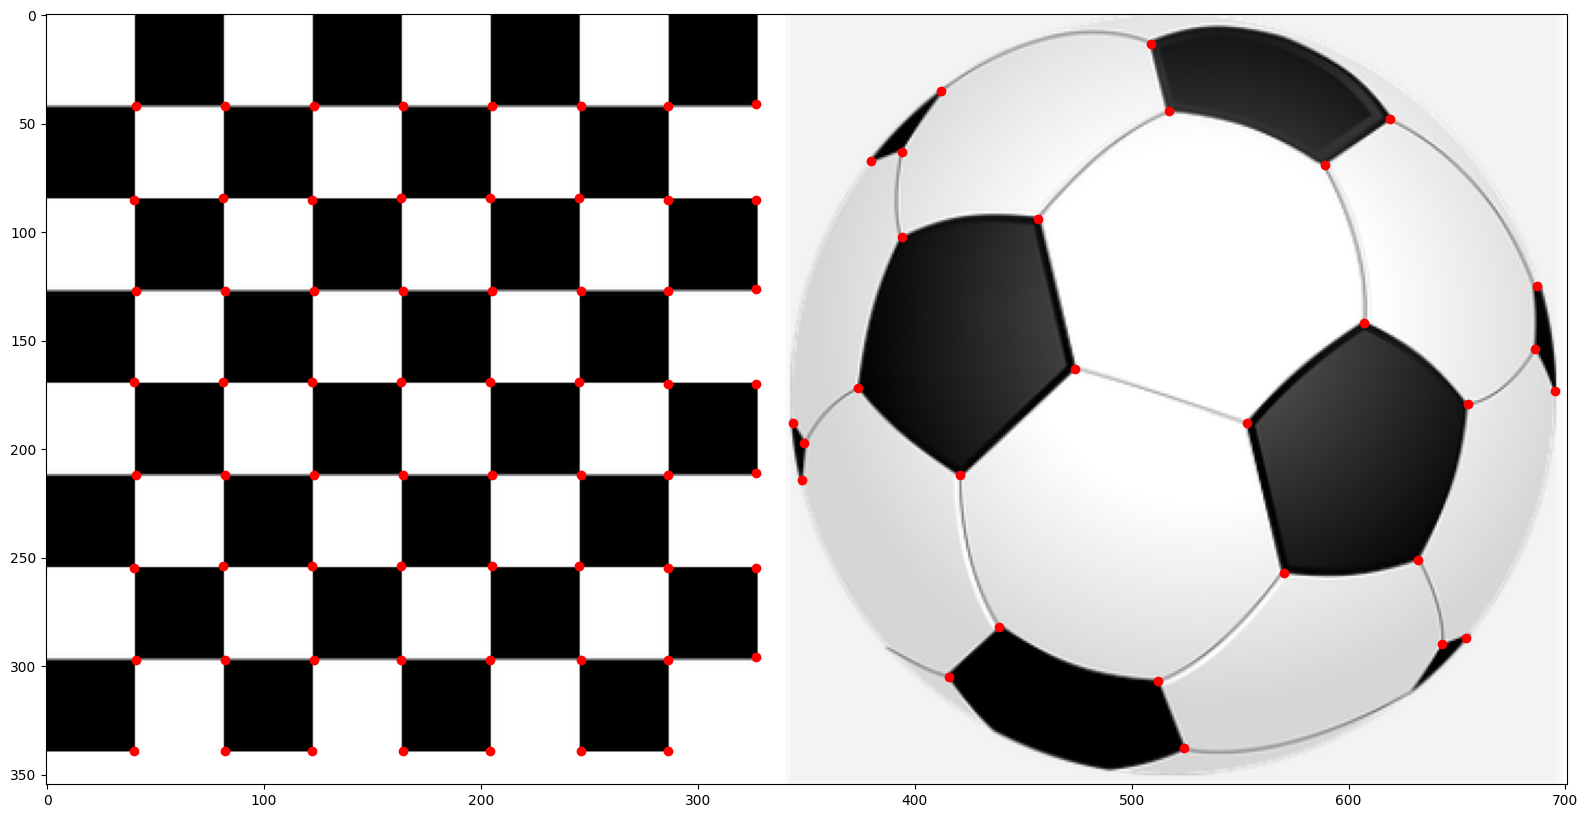

In [17]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_peaks
import matplotlib.pyplot as plt

image = imread('../images/chess_football.png')

# Kiểm tra nếu ảnh có 4 kênh (RGBA), chuyển về 3 kênh (RGB) trước khi chuyển sang grayscale
if image.shape[-1] == 4:
    image = image[:, :, :3]  # Loại bỏ kênh alpha

image_gray = rgb2gray(image)
harris_response = corner_harris(image_gray, k=0.04)
corners = corner_peaks(harris_response, min_distance=5, threshold_rel=0.02)

plt.figure(figsize=(20, 10))
plt.imshow(image, cmap='gray')  # Dùng ảnh gốc để hiển thị (RGB hoặc RGBA)
plt.scatter(corners[:, 1], corners[:, 0], marker='o', color='red', label='Corners')  # Vẽ các điểm góc
plt.show()

### Blob detectors with LoG, DoG and DoH

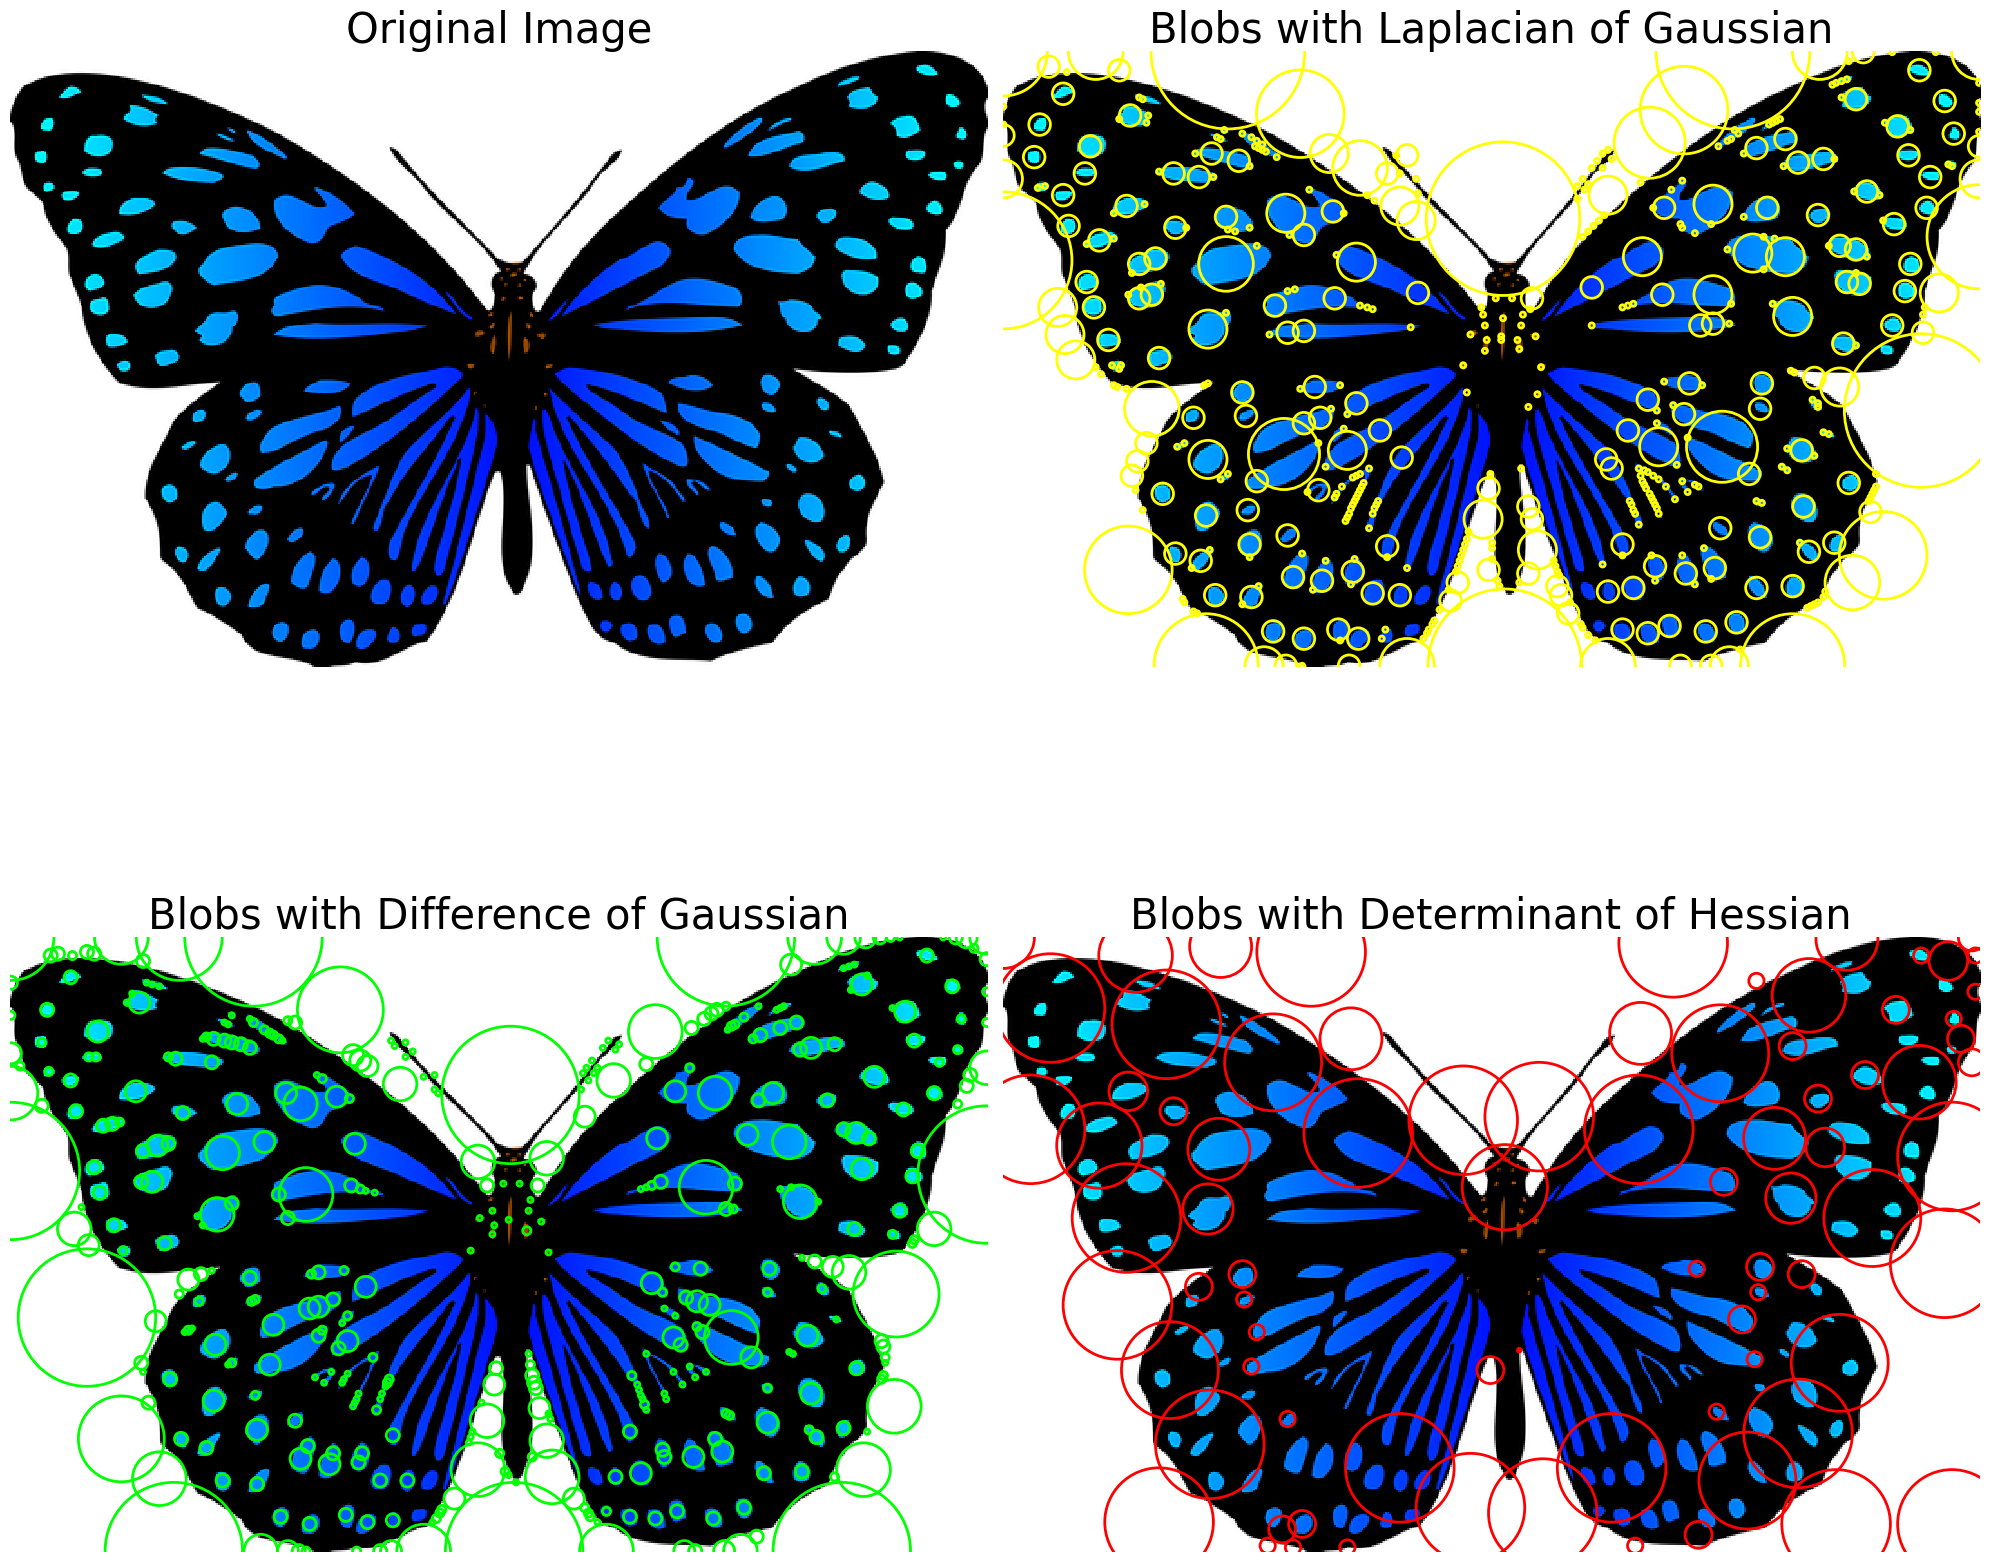

In [18]:
# 1.  Import thư viện cần thiết
from numpy import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.io import imread
from skimage.color import rgb2gray
from matplotlib import pylab

# 2. Đọc và xử lý ảnh
im = imread('../images/butterfly.png')
# Convert RGBA to RGB if needed
if im.shape[-1] == 4:
    im = rgba2rgb(im)
im_gray = rgb2gray(im)

# 3. Phát hiện blob bằng các thuật toán khác nhau
# Laplacian of Gaussian (LoG)
log_blobs = blob_log(im_gray, max_sigma=30, num_sigma=10, threshold=0.1)
log_blobs[:, 2] = sqrt(2) * log_blobs[:, 2]  # Chuyển bán kính thành dạng chuẩn

# Difference of Gaussian (DoG)
dog_blobs = blob_dog(im_gray, max_sigma=30, threshold=0.1)
dog_blobs[:, 2] = sqrt(2) * dog_blobs[:, 2]

# Determinant of Hessian (DoH)
doh_blobs = blob_doh(im_gray, max_sigma=30, threshold=0.005)

# 4. Hiển thị kết quả phát hiện blob
# Danh sách blob, màu và tiêu đề tương ứng
list_blobs = [log_blobs, dog_blobs, doh_blobs]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(list_blobs, colors, titles)

# Tạo hình ảnh phụ (subplots)
fig, axes = pylab.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.ravel()

# Hiển thị ảnh gốc
axes[0].imshow(im, interpolation='nearest')
axes[0].set_title('Original Image', size=30)
axes[0].set_axis_off()

# Hiển thị các blob trên ảnh
for idx, (blobs, color, title) in enumerate(sequence):
    axes[idx + 1].imshow(im, interpolation='nearest')
    axes[idx + 1].set_title('Blobs with ' + title, size=30)
    for blob in blobs:
        y, x, radius = blob
        circle = pylab.Circle((x, y), radius, color=color, linewidth=2, fill=False)
        axes[idx + 1].add_patch(circle)
    axes[idx + 1].set_axis_off()

pylab.tight_layout()
pylab.show()

### Compute HOG descriptors with scikit-image

Image: ../images/cameraman.jpg
Image shape: (256, 256), Feature descriptor length: 2048
Image: ../images/parrot.jpg
Image shape: (340, 453), Feature descriptor length: 4704
Image: ../images/horse.jpg
Image shape: (480, 677), Feature descriptor length: 10080


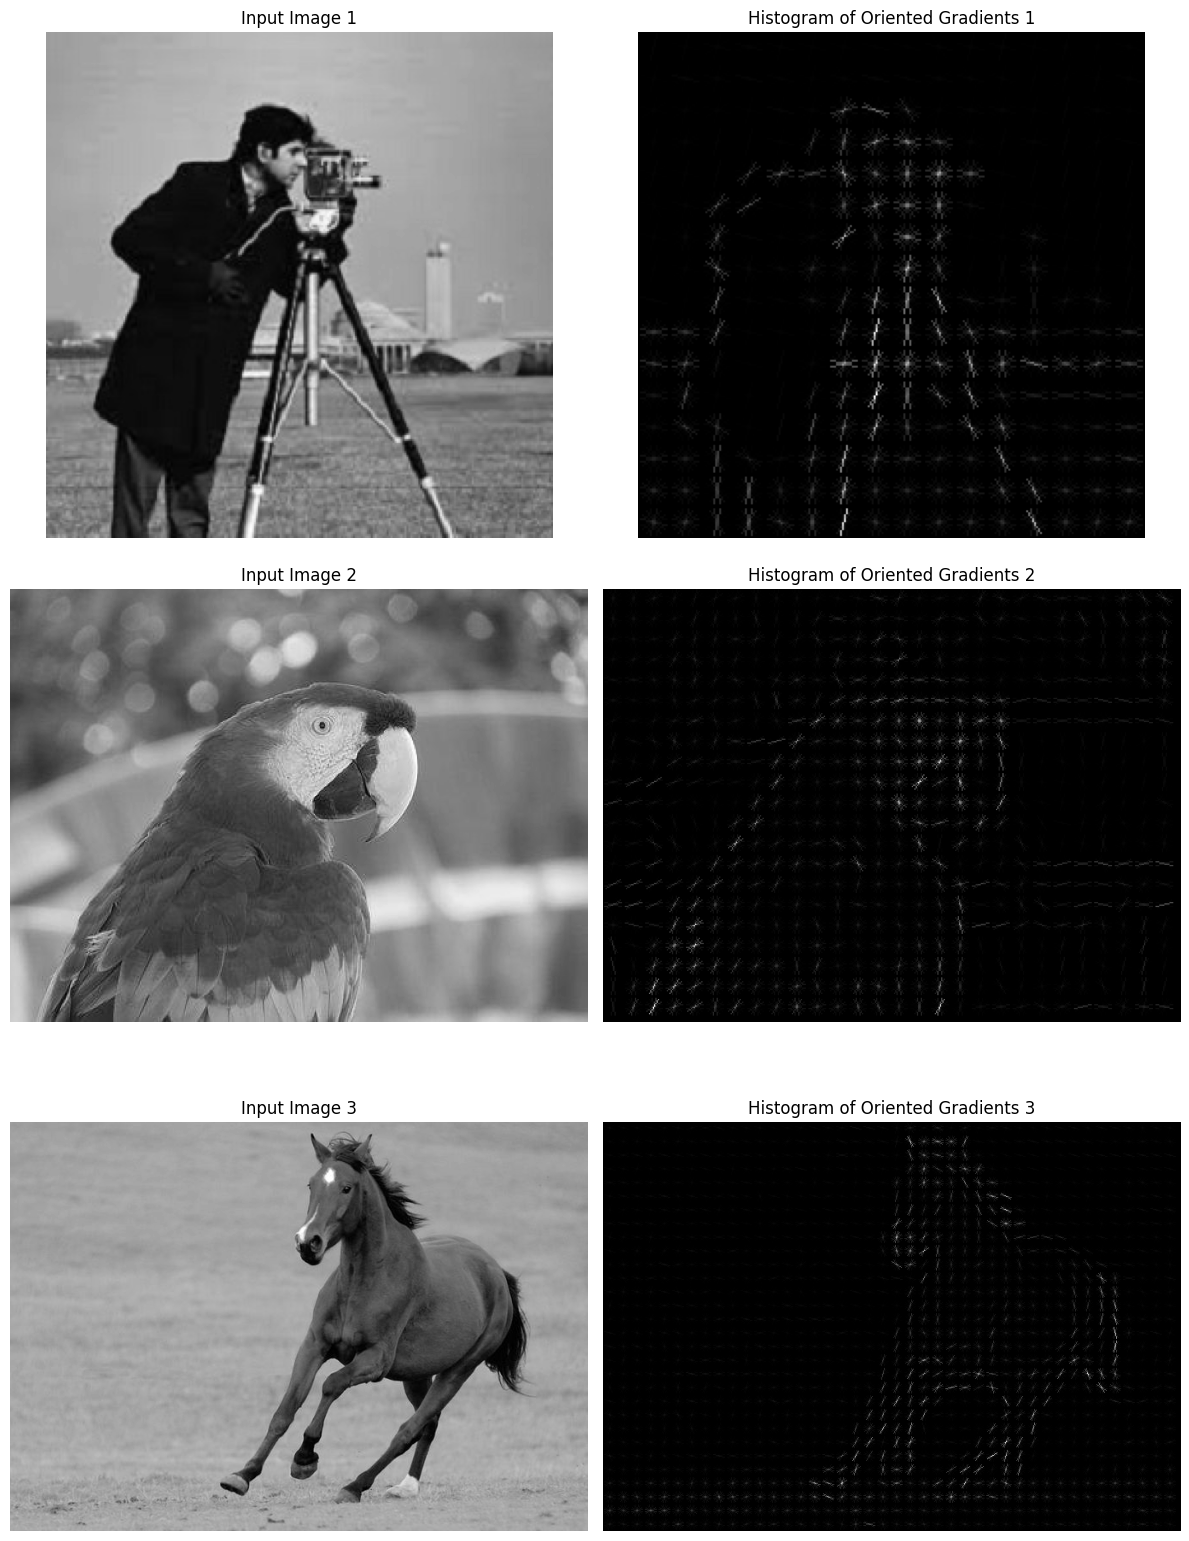

In [6]:
# 1. Import thư viện cần thiết
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt

# Hàm xử lý HOG cho từng ảnh
def process_hog(image_path, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)):
    # Đọc và chuyển sang grayscale
    image = rgb2gray(imread(image_path))
    
    # Tính đặc trưng HOG
    fd, hog_image = hog(image, 
                        orientations=orientations, 
                        pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block, 
                        visualize=True)
    
    # In thông tin đầu ra
    print(f"Image: {image_path}")
    print(f"Image shape: {image.shape}, Feature descriptor length: {len(fd)}")
    
    return image, hog_image

# Danh sách đường dẫn ảnh
image_paths = [
    '../images/cameraman.jpg',
    '../images/parrot.jpg',
    '../images/horse.jpg'
]

# Tạo figure với 3 hàng, 2 cột
fig, axs = plt.subplots(3, 2, figsize=(12, 16))

# Xử lý và hiển thị từng ảnh
for i, image_path in enumerate(image_paths):
    # Xử lý ảnh
    original_image, hog_image = process_hog(image_path)
    
    # Hiển thị ảnh gốc
    axs[i, 0].axis('off')
    axs[i, 0].imshow(original_image, cmap=plt.cm.gray)
    axs[i, 0].set_title(f'Input Image {i+1}')
    
    # Hiển thị ảnh HOG
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    axs[i, 1].axis('off')
    axs[i, 1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
    axs[i, 1].set_title(f'Histogram of Oriented Gradients {i+1}')

# Điều chỉnh layout
plt.tight_layout()
plt.show()

### Scale-invariant feature transform (SIFT)

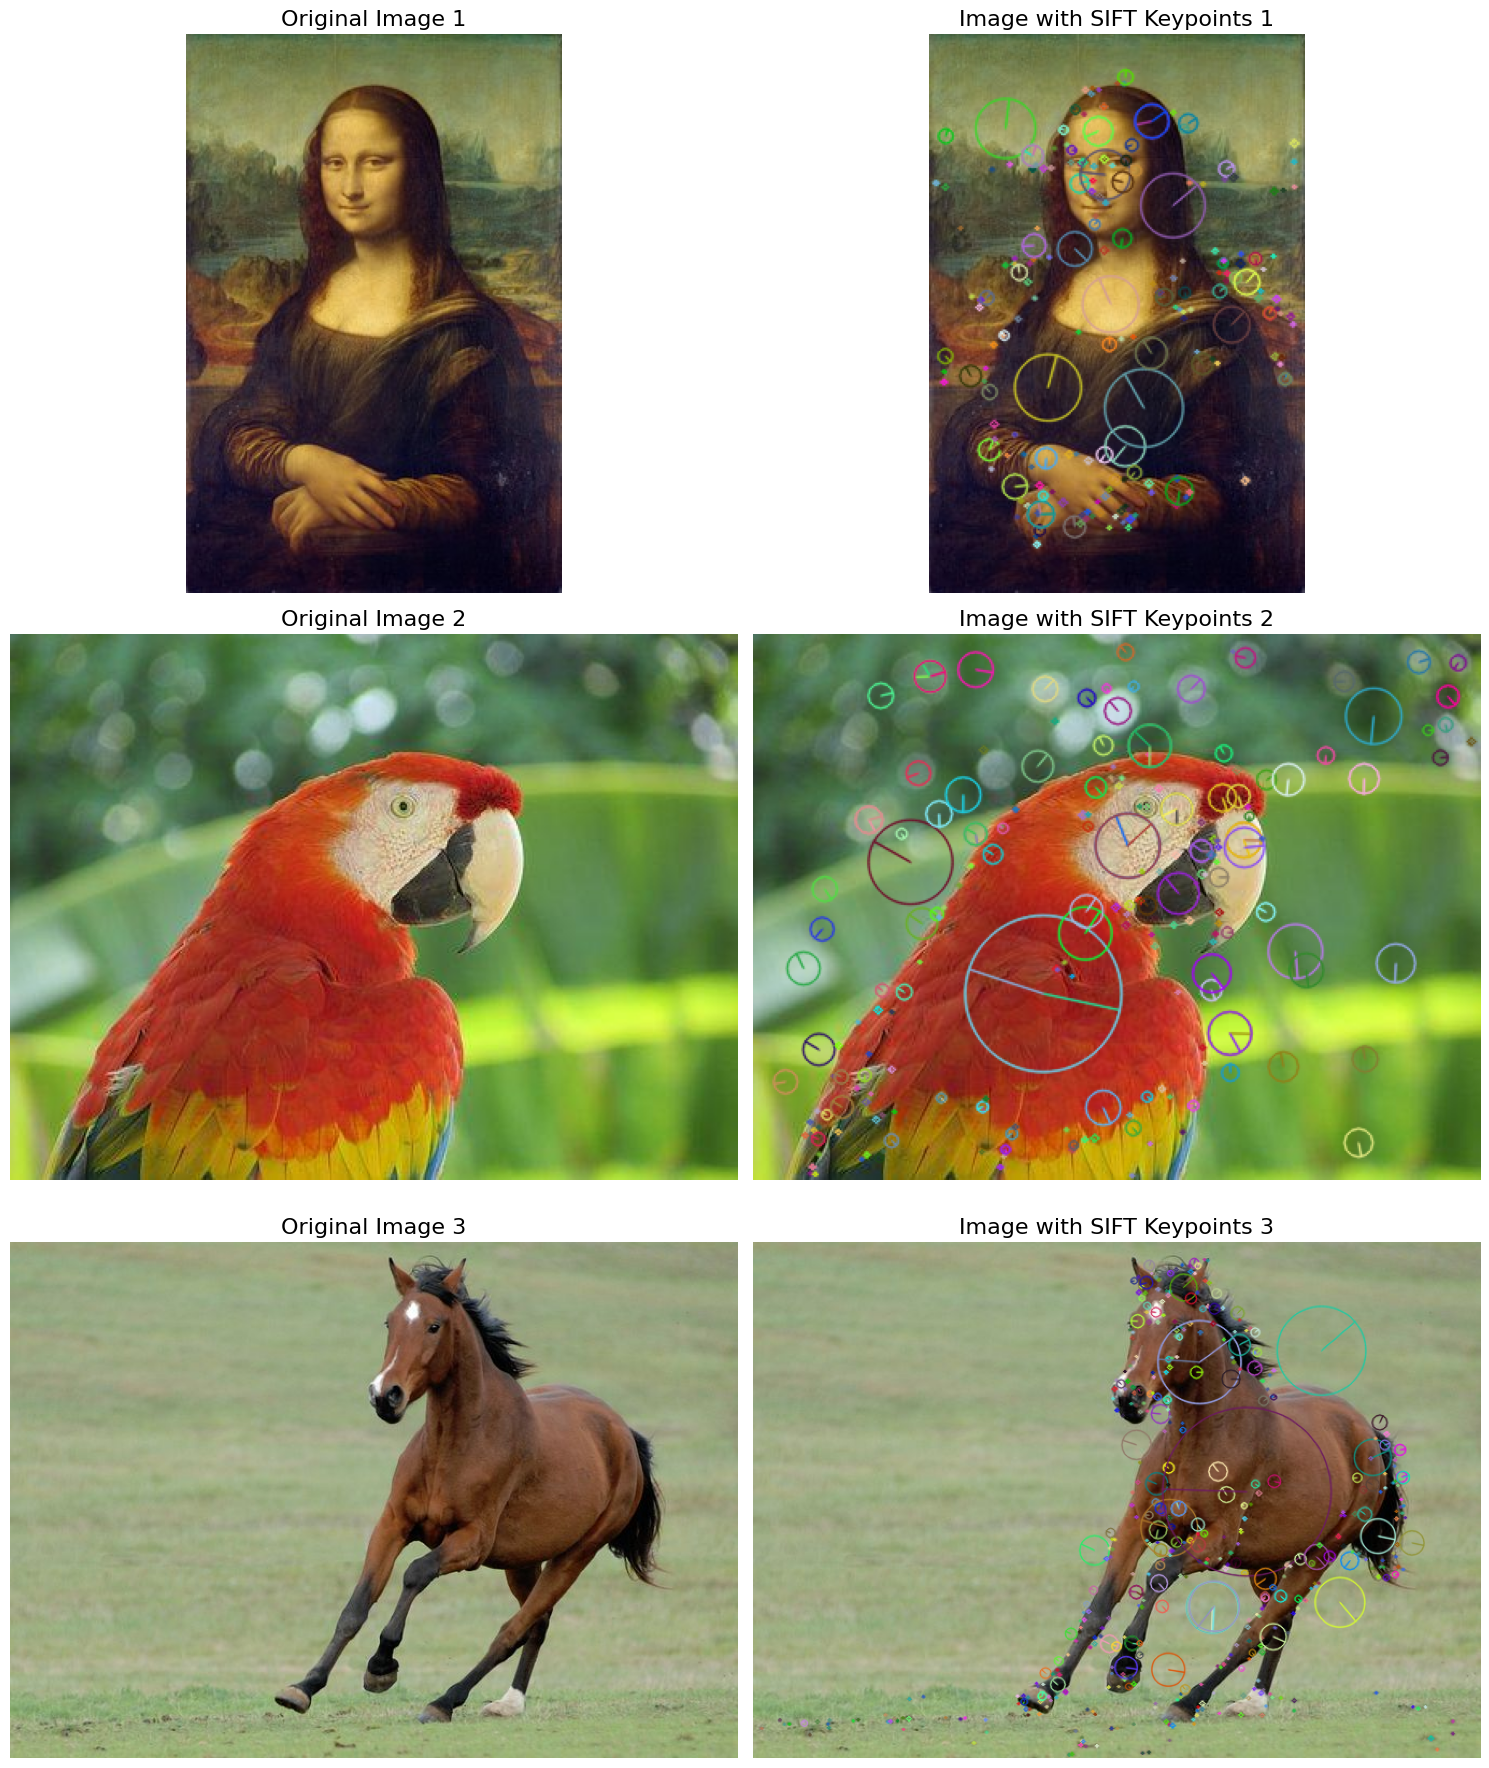

In [5]:
import cv2
import matplotlib.pyplot as plt

def process_image(image_path):
    # Đọc ảnh
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found. Check the path: {image_path}")
    
    # Chuyển ảnh sang xám
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Tạo đối tượng SIFT và phát hiện keypoints
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    
    # Vẽ keypoints trên ảnh
    img_with_keypoints = cv2.drawKeypoints(
        img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    return img, img_with_keypoints

# Danh sách đường dẫn ảnh
image_paths = [
    '../images/monalisa.jpg', 
    '../images/parrot.jpg',   # Thay đổi đường dẫn ảnh thứ 2
    '../images/horse.jpg'    # Thay đổi đường dẫn ảnh thứ 3
]

# Tạo figure với 3 hàng, 2 cột
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Xử lý và hiển thị từng ảnh
for i, image_path in enumerate(image_paths):
    # Xử lý ảnh
    original_img, sift_img = process_image(image_path)
    
    # Hiển thị ảnh gốc
    axs[i, 0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title(f"Original Image {i+1}", fontsize=16)
    axs[i, 0].axis("off")
    
    # Hiển thị ảnh với SIFT keypoints
    axs[i, 1].imshow(cv2.cvtColor(sift_img, cv2.COLOR_BGR2RGB))
    axs[i, 1].set_title(f"Image with SIFT Keypoints {i+1}", fontsize=16)
    axs[i, 1].axis("off")

# Điều chỉnh layout
plt.tight_layout()
plt.show()

### Binary Robust Independent Elementary Features (BRIEF)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15728\1920629381.py:62: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(axes[0], img1, img2, keypoints1, keypoints2, matches12)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15728\1920629381.py:67: FutureWarning: `plot_matches` is deprecated since version 0.23 and will be removed in version 0.25. Use `skimage.feature.plot_matched_features` instead.
  plot_matches(axes[1], img1, img3, keypoints1, keypoints3, matches13)


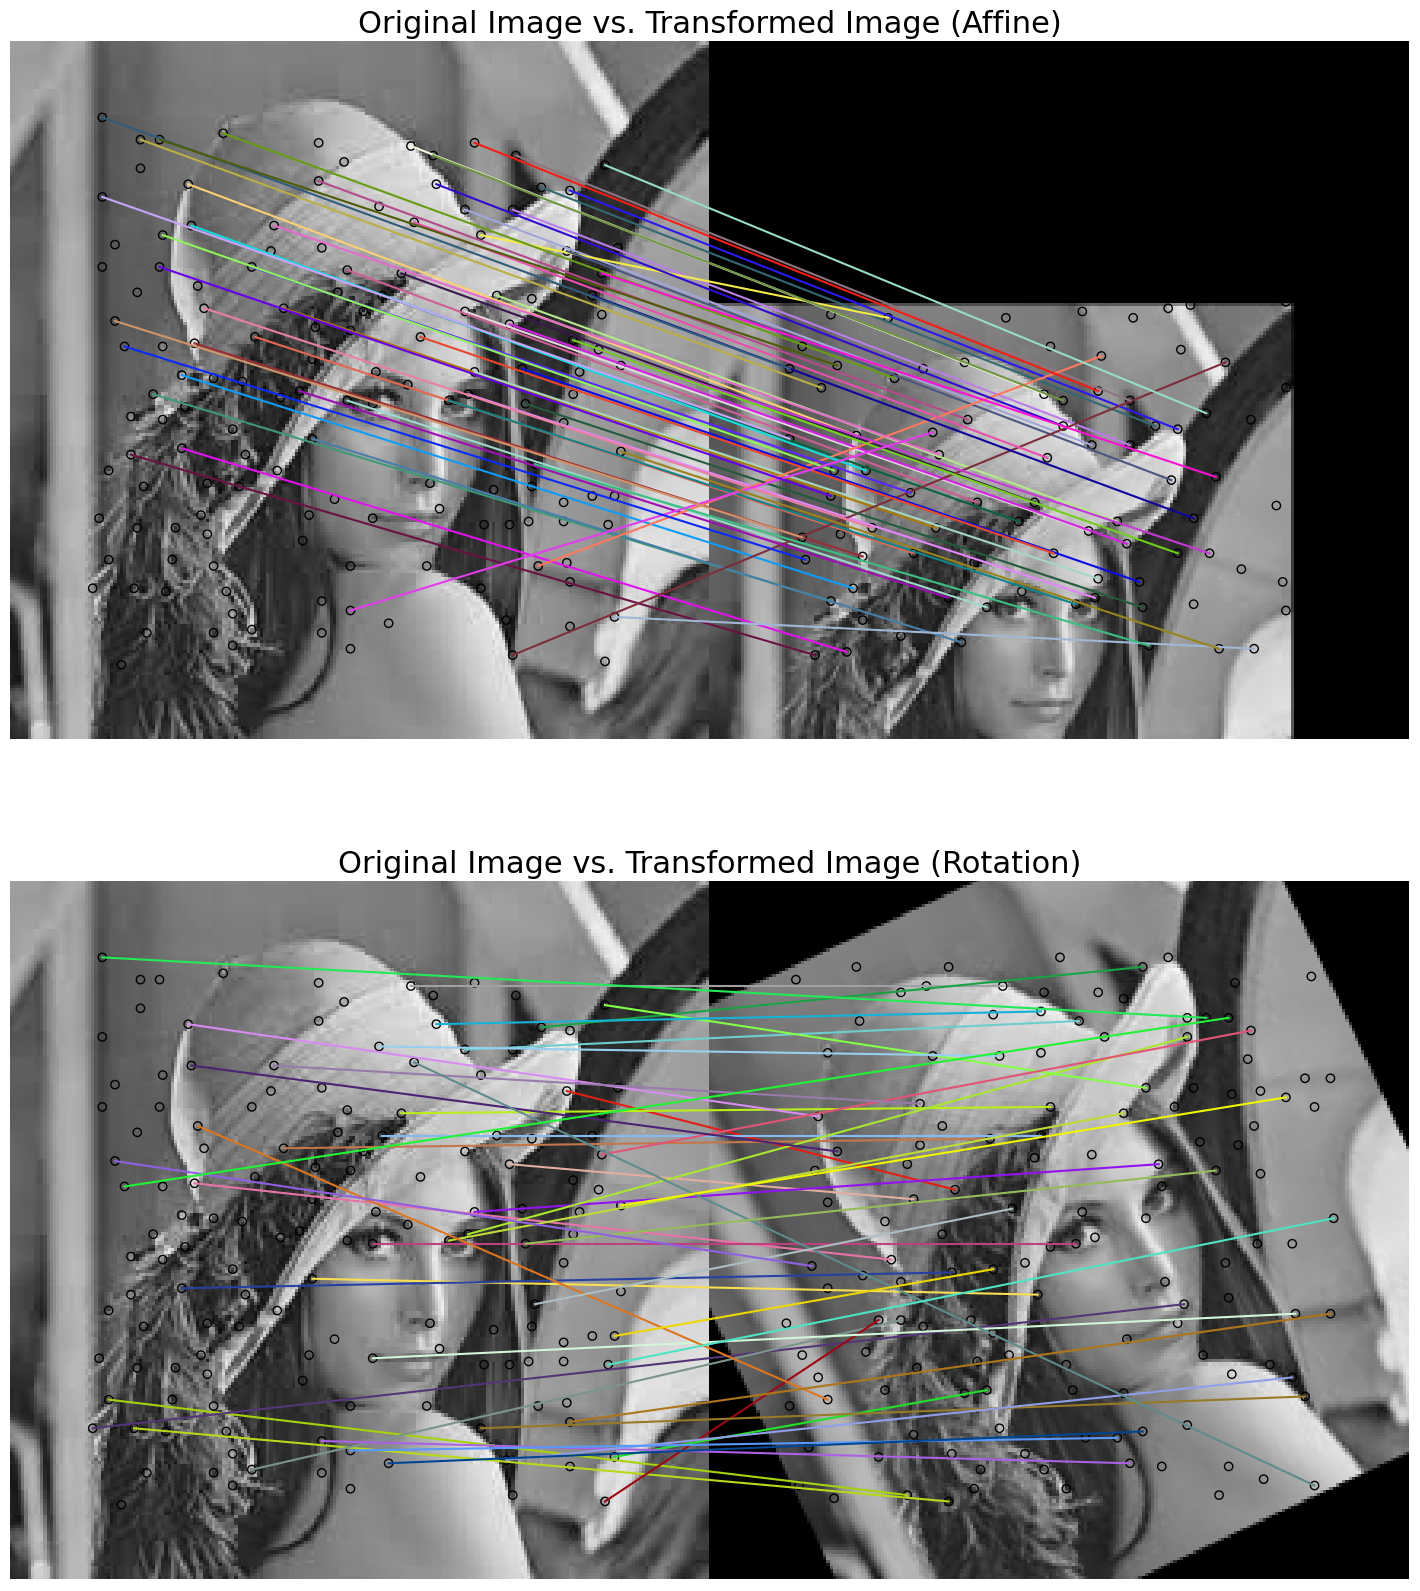

In [21]:

# 1. Import các thư viện cần thiết
from skimage import transform as transform
from skimage.feature import (
    match_descriptors, corner_peaks, corner_harris, plot_matches, BRIEF
)
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import pylab

# 2. Chuẩn bị ảnh
# Đọc và chuyển đổi ảnh sang grayscale
img1 = rgb2gray(imread('../images/lena.jpg'))

# Biến đổi Affine: phóng to và dịch chuyển
affine_trans = transform.AffineTransform(scale=(1.2, 1.2), translation=(0, -100))
img2 = transform.warp(img1, affine_trans)

# Xoay ảnh một góc 25 độ
img3 = transform.rotate(img1, 25)

# 3. Phát hiện keypoints
# Tính toán Corner Harris
coords1, coords2, coords3 = corner_harris(img1), corner_harris(img2), corner_harris(img3)

# Ngưỡng hóa kết quả Corner Harris
coords1[coords1 > 0.01 * coords1.max()] = 1
coords2[coords2 > 0.01 * coords2.max()] = 1
coords3[coords3 > 0.01 * coords3.max()] = 1

# Phát hiện tọa độ các điểm keypoints
keypoints1 = corner_peaks(coords1, min_distance=5)
keypoints2 = corner_peaks(coords2, min_distance=5)
keypoints3 = corner_peaks(coords3, min_distance=5)

# 4. Tính toán descriptors
# Tạo đối tượng BRIEF để trích xuất descriptors
extractor = BRIEF()

# Trích xuất descriptors cho từng ảnh
extractor.extract(img1, keypoints1)
keypoints1, descriptors1 = keypoints1[extractor.mask], extractor.descriptors

extractor.extract(img2, keypoints2)
keypoints2, descriptors2 = keypoints2[extractor.mask], extractor.descriptors

extractor.extract(img3, keypoints3)
keypoints3, descriptors3 = keypoints3[extractor.mask], extractor.descriptors

# 5. So khớp descriptors
# So khớp descriptors giữa ảnh gốc và các ảnh biến đổi
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches13 = match_descriptors(descriptors1, descriptors3, cross_check=True)


# 6. Hiển thị kết quả
# Hiển thị các kết quả so khớp
fig, axes = pylab.subplots(nrows=2, ncols=1, figsize=(20, 20))
pylab.gray()

# Ảnh gốc vs ảnh biến đổi Affine
plot_matches(axes[0], img1, img2, keypoints1, keypoints2, matches12)
axes[0].axis('off')
axes[0].set_title("Original Image vs. Transformed Image (Affine)", fontsize=22)

# Ảnh gốc vs ảnh xoay
plot_matches(axes[1], img1, img3, keypoints1, keypoints3, matches13)
axes[1].axis('off')
axes[1].set_title("Original Image vs. Transformed Image (Rotation)", fontsize=22)

pylab.show()